# Demo: Using a Google Earth engine


This example is the continuation of the previous example: [Using a Dataset](https://metobs-toolkit.readthedocs.io/en/latest/examples/doc_example.html). This example serves as a demonstration on how to get meta-data from the Google Earth Engine (GEE). 

Before proceeding, make sure you have **set up a Google developers account and a GEE project**. See [Using Google Earth Engine](https://metobs-toolkit.readthedocs.io/en/latest/topics/gee_authentication.html#using-google-earth-engine) for a detailed description of this.

There are two classes that facilitate the interaction with GEE and the metobs_toolkit:

 * `GeeStaticModelData`: This class handles GEE Datasets that do not have a time dimension (static). This class is used to extract GEE dataset values at the location of the station (or buffers around them).
 * `GeeDynamicModelData`: This class handles GEE Datasets that have a time dimension. This class is used to extract timeseries of GEE dataset values at the stations locations.

Both classes can hold metadata (=Coordinates of the stations), and the ´GeeDynamicModelData` class can hold timeseries data.

In this example, we first demonstrate the `GeeStaticModelData` to extract extra metadata for the stations. Then we demonstrate how to extract timeseries at the station locations using `GeeDynamicModelData`.

## Create your Dataset

Create a dataset with the demo data.

In [1]:
import metobs_toolkit

your_dataset = metobs_toolkit.Dataset()
your_dataset.update_file_paths(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

your_dataset.import_data_from_file()

Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.


Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.


Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.


Rukwind is present in the datafile, but not found in the template! This column will be ignored.


Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.


Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.


The following columns are found in the metadata, but not in the template and are therefore ignored: 
['benaming', 'stad', 'sponsor', 'Network']


## Extracting LCZ from GEE

Here is an example of how to extract the Local Climate Zone (LCZ) information of your stations. First, we take a look at what is present in the metadata of the dataset. 

In [2]:
your_dataset.metadf.head()

,lat,lon,school,geometry,dataset_resolution,dt_start,dt_end
name,,,,,,,
vlinder01,50.980438,3.815763,UGent,POINT (3.81576 50.98044),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder02,51.022379,3.709695,UGent,POINT (3.7097 51.02238),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder03,51.324583,4.952109,Heilig Graf,POINT (4.95211 51.32458),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder04,51.335522,4.934732,Heilig Graf,POINT (4.93473 51.33552),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder05,51.052655,3.675183,Sint-Barbara,POINT (3.67518 51.05266),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00


To extract geospatial information for your stations, the **lat** and **lon** (latitude and longitude)
of your stations must be present in the metadf. If so, then geospatial
information will be extracted from GEE at these locations.

To extract the Local Climate Zones (LCZs) of your stations:

In [3]:
lcz_values = your_dataset.get_lcz()
# The LCZs for all your stations are extracted
print(lcz_values)

                               lcz
name                              
vlinder01       Low plants (LCZ D)
vlinder02            Large lowrise
vlinder03             Open midrise
vlinder04           Sparsely built
vlinder05            Water (LCZ G)
vlinder06  Scattered Trees (LCZ B)
vlinder07          Compact midrise
vlinder08          Compact midrise
vlinder09  Scattered Trees (LCZ B)
vlinder10          Compact midrise
vlinder11             Open lowrise
vlinder12            Open highrise
vlinder13          Compact midrise
vlinder14       Low plants (LCZ D)
vlinder15       Low plants (LCZ D)
vlinder16            Water (LCZ G)
vlinder17  Scattered Trees (LCZ B)
vlinder18       Low plants (LCZ D)
vlinder19          Compact midrise
vlinder20          Compact midrise
vlinder21           Sparsely built
vlinder22       Low plants (LCZ D)
vlinder23       Low plants (LCZ D)
vlinder24      Dense Trees (LCZ A)
vlinder25            Water (LCZ G)
vlinder26             Open midrise
vlinder27          C

The first time, in each session, you are asked to authenticated by Google.
Select your Google account and billing project that you have set up and accept the terms of the condition.

*NOTE: For small data-requests the read-only scopes are sufficient, for large data-requests this is insufficient because the data will be written directly to your Google Drive.*

The metadata of your dataset is also updated

In [4]:
print(your_dataset.metadf['lcz'].head())

name
vlinder01    Low plants (LCZ D)
vlinder02         Large lowrise
vlinder03          Open midrise
vlinder04        Sparsely built
vlinder05         Water (LCZ G)
Name: lcz, dtype: object


To make a geospatial plot you can use the following method:

<GeoAxes: title={'center': 'lcz'}>

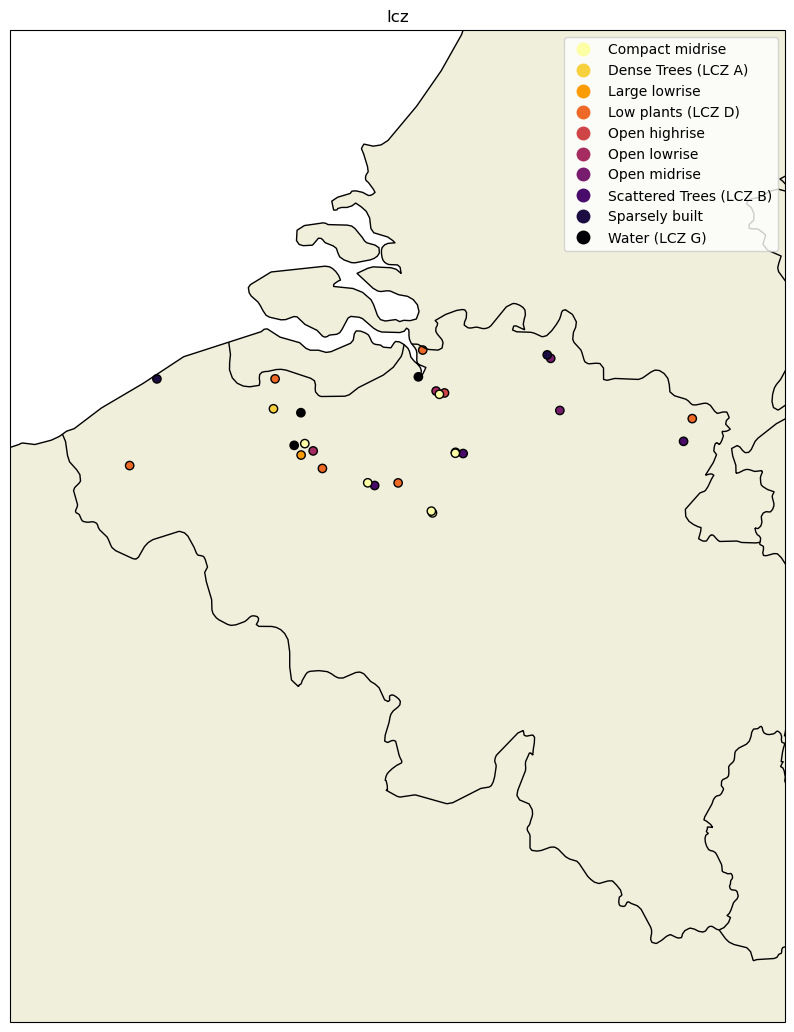

In [5]:
your_dataset.make_geo_plot(variable="lcz")

## Extracting other Geospatial information

Similar as LCZ extraction you can extract the altitude of the stations (from a digital elevation model):

In [6]:
altitudes = your_dataset.get_altitude() #The altitudes are in meters above sea level.
print(altitudes)

           altitude
name               
vlinder01        12
vlinder02         7
vlinder03        30
vlinder04        25
vlinder05         0
vlinder06         0
vlinder07         7
vlinder08         7
vlinder09        19
vlinder10        14
vlinder11         6
vlinder12         9
vlinder13        10
vlinder14         4
vlinder15        41
vlinder16         4
vlinder17        83
vlinder18        35
vlinder19        75
vlinder20        44
vlinder21        19
vlinder22         3
vlinder23         1
vlinder24        12
vlinder25        12
vlinder26        24
vlinder27        12
vlinder28         7


A more detailed description of the landcover/land use in the microenvironment can be extracted in the form of landcover fractions in a circular buffer for each station.

You can select to aggregate the landcover classes to water - pervious and impervious, or set aggregation to false to extract the landcover classes as present in the worldcover_10m dataset.

In [7]:
aggregated_landcover = your_dataset.get_landcover(
                                        buffers=[100, 250], # a list of buffer radii in meters
                                        aggregate=True #if True, aggregate landcover classes to the water, pervious and impervious.
                                        )

print(aggregated_landcover)

                            water  pervious  impervious
name      buffer_radius                                
vlinder01 100            0.000000  0.981781    0.018219
          250            0.000000  0.963635    0.036365
vlinder02 100            0.000000  0.428769    0.571231
          250            0.000000  0.535944    0.464056
vlinder03 100            0.000000  0.245454    0.754546
          250            0.000000  0.160831    0.839169
vlinder04 100            0.000000  0.979569    0.020431
          250            0.000000  0.881948    0.118052
vlinder05 100            0.446604  0.224871    0.328525
          250            0.242406  0.526977    0.230617
vlinder06 100            0.000000  1.000000    0.000000
          250            0.000000  0.995819    0.004181
vlinder07 100            0.000000  0.433034    0.566966
          250            0.002911  0.149681    0.847407
vlinder08 100            0.000000  0.029552    0.970448
          250            0.002911  0.030423    0

### Plotting with GeeStaticModelData 

You can make an interactive plot of a `GeeStaticModelData`, by using the `GeeStaticModelData.make_gee_plot()` method.

*Note: Not all Python environments can visualize the interactive map. If that is the case for you, you can save the map
as a (html) file, and open it with your browser.*

In [8]:
# The (default) Gee Modeldata is stored in all Datasets
your_dataset.gee_datasets

{'lcz': GeeStaticModelData instance of lcz  (known metadata),
 'altitude': GeeStaticModelData instance of altitude  (known metadata),
 'worldcover': GeeStaticModelData instance of worldcover  (known metadata),
 'ERA5-land': Empty GeeDynamicModelData instance of ERA5-land }

We can see 'lcz' is a known GeeStaticModelData, so we can plot it

In [9]:
lcz_map = your_dataset.gee_datasets['lcz']

In [10]:
#Make the plot
your_dataset.make_gee_static_spatialplot(Model=your_dataset.gee_datasets['lcz'])

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/modeldata.py:1056: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = self.metadf.dissolve().centroid


*note : In the online documentation, no GEE data is shown. This is because the map is interactive, and requires GEE authentication which is not publicly available.*

## Extracting ERA5 timeseries 

Now we demonstrate how to use the `GeeDynamicModelData`, and use the ERA5-land (GEE) dataset for it.
All available Gee Modeldata's for your Dataset are stored in the `GeeDynamicModelData.gee_datasets`.

In [11]:
your_dataset.gee_datasets

{'lcz': GeeStaticModelData instance of lcz  (known metadata),
 'altitude': GeeStaticModelData instance of altitude  (known metadata),
 'worldcover': GeeStaticModelData instance of worldcover  (known metadata),
 'ERA5-land': Empty GeeDynamicModelData instance of ERA5-land }

In [12]:
era5_model = your_dataset.gee_datasets['ERA5-land']
era5_model.get_info()

Empty GeeDynamicModelData instance of ERA5-land 
------ Details --------- 

 * name: ERA5-land
 * location: ECMWF/ERA5_LAND/HOURLY
 * value_type: numeric
 * scale: 2500
 * is_static: False
 * is_image: False
 * is_mosaic: False
 * credentials: 
 * time res: 1h

 -- Known Modelobstypes -- 

 * temp : ModelObstype instance of temp (linked to band: temperature_2m)
    (conversion: Kelvin --> Celsius)
 * pressure : ModelObstype instance of pressure (linked to band: surface_pressure)
    (conversion: pa --> pa)
 * wind : ModelObstype_Vectorfield instance of wind (linked to bands: u_component_of_wind_10m and v_component_of_wind_10m)
    vectorfield that will be converted to: 
      * wind_speed
      * wind_direction
    (conversion: m/s --> m/s)

 -- Metadata -- 

No metadf is set.

 -- Modeldata -- 

No model data is set.


We can see that *temp* is a known `ModelObstype` present in the era_model. Thus we can use it to extract temperature timeseries. 

If the target `ModelObstype` is not present, create the `ModelObstype` and add it with `GeeDynamicModelData.add_modelobstype()`.


The toolkit has built-in functionality to extract ERA5 time series at the station locations. The ERA5 data will be stored in a [Modeldata](https://metobs-toolkit.readthedocs.io/en/latest/reference/modeldata.html) instance. Here is an example on how to get the ERA5 time series by using the ``get_modeldata()`` method.

In [13]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None} #else the legend is cutoff in ipython inline plots

GeeDynamicModelData instance of ERA5-land with modeldata 


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, outliersdf])  # combine the two


<Axes: title={'center': 'ERA5-land and temp observations.'}, ylabel='temp (Celsius)\n originates from temperature_2m'>

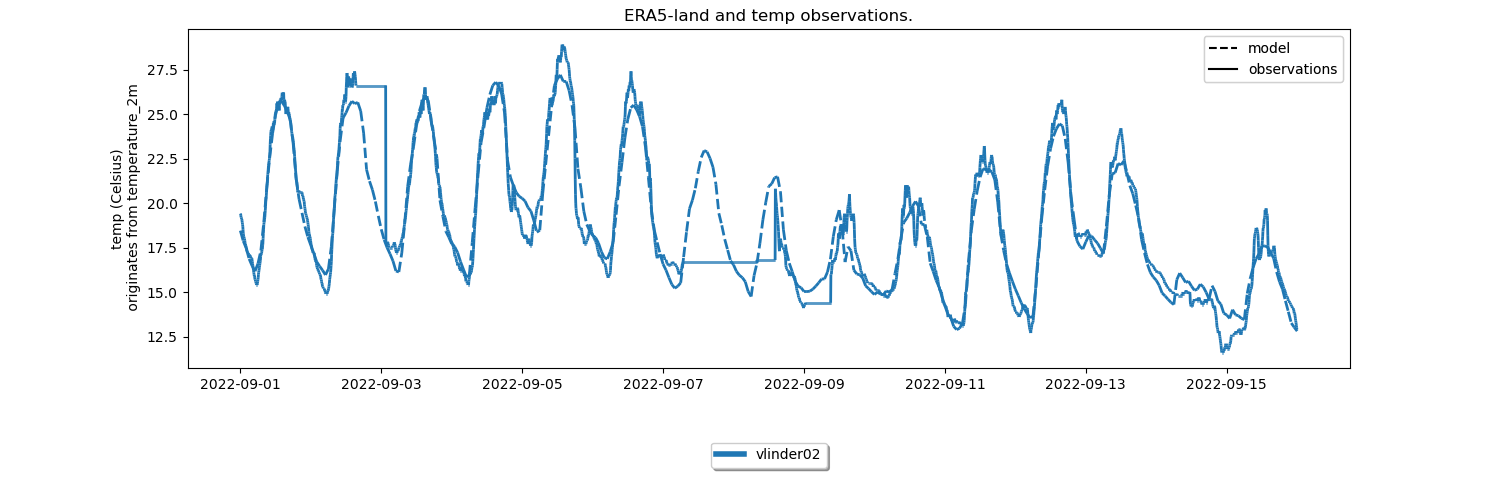

In [14]:
#Get the ERA5 data for a single station (to reduce data transfer)
your_station = your_dataset.get_station('vlinder02')

#Extract time series at the location of the station
ERA5_data = your_station.get_modeldata(Model=era5_model, 
                                       obstypes=['temp'], 
                                       startdt=None, #if None, the start of the observations is used 
                                       enddt=None, #if None, the end of the observations is used 
                                       get_all_bands=False #if True, all the GEE bands are extracted.
                                       )

#Get info
print(ERA5_data)
ERA5_data.make_plot(obstype_model='temp', 
                    Dataset=your_station, #add the observations to the same plot 
                    obstype_dataset='temp')


### GEE data transfer

There is a limit to the amount of data that can be transferred directly from GEE. When the data cannot be transferred directly, **it will be written to a file on your Google Drive**. The location of the file will be printed out. When the writing to the file is done, you must download the file and import it to an empty *Modeldata* instance using the ``set_model_from_csv()`` method. 

In [15]:
#Illustration
#Extract time series at the locations all the station
ERA5_data = your_dataset.get_modeldata(Model=era5_model, 
                                       obstypes=['temp'], 
                                       startdt=None, #if None, the start of the observations is used 
                                       enddt=None, #if None, the end of the observations is used 
                                       force_to_drive=True, #We can force it to use Google Drive
                                       )

#Because the data amount is too large (or because of the force_to_drive),
# it will be written to a file on your Google Drive! The returned Modeldata is empty.
print(ERA5_data)


The timeseries will be written to your Drive in gee_timeseries_data/ERA5-land_timeseries_data 


The data is transfered! Open the following link in your browser: 


https://drive.google.com/#folders/1QE0DA-YqeHh5gSUG2L1EWh7ndyxa7xNj 


To upload the data to the model, use the Modeldata.set_model_from_csv() method
GeeDynamicModelData instance of ERA5-land with modeldata 


In [16]:
#See the output to find the modeldata in your Google Drive, and download the file.
#Update the empty Modeldata with the data from the file

#ERA5_data.set_model_from_csv(csvpath='/home/..../era5_data.csv') #The path to the downloaded file
#print(ERA5_data)

## Plotting with GeeDynamicModelData

You can make an interactive spatial plot to visualize the stations spatially by using the ``make_gee_plot()``.

In [17]:
str(your_dataset)


"Dataset instance containing:\n     *28 stations\n     *['humidity', 'temp', 'wind_direction', 'wind_speed'] observation types present\n     *483828 observation records (not Nan's)\n     *0 records labeled as outliers\n     *8 gaps\n     *records range: 2022-09-01 00:00:00+00:00 --> 2022-09-15 23:55:00+00:00 (total duration:  14 days 23:55:00)\n     *time zone of the records: UTC\n     *Coordinates are available for all stations.\n     *Known GEE datasets for: ['lcz', 'altitude', 'worldcover', 'ERA5-land']"

In [18]:
import datetime
at_time = datetime.datetime(2022,9,12,16)
print(at_time)

spatial_map = your_dataset.make_gee_dynamic_spatialplot(
                            timeinstance=at_time,
                            Model=era5_model,
                            modelobstype='temp',
                            vmin=None, #if none, toolkit makes a guess based on your stations
                            vmax=None) #if none, toolkit makes a guess based on your stations)
spatial_map

2022-09-12 16:00:00


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/modeldata.py:1806: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = self.metadf.dissolve().centroid


*note : In the online documentation, no GEE data is shown. This is because the map is interactive, and requires GEE authentication which is not publicly available.*